# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# Extract cell activity and trial variables form simulation results

In [2]:
# Initialize arrays of interest variables 
# NOTE: each neuron's activity is a row; column index is trial number

N_PFC_NEURONS = 500
N_MD_NEURONS = 2
N_OUTPUT_NEURONS = 2
TRIAL_TIME = 200

s_trial = 0
t_trial = 4800
n_trials = t_trial - s_trial

rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
rMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
task_input = np.zeros((2, n_trials))
v1v2_values = np.zeros((2, n_trials))

# Extract the data

data_dir = "/om2/group/halassa/PFCMD-ali-sabrina/020321_qvals/by_trial"

for i in range(s_trial, t_trial):
    with open(data_dir + "/" + str(i) + ".json") as json_file:
        data = json.load(json_file)
        idx = i - s_trial
                
        rPFC = np.array(data["network_rates"]["r_PFC"])
        rPFC_trials[idx,:,:] = rPFC
        
        rMD = np.array(data["network_rates"]["r_MD"])
        rMD_trials[idx,:,:] = rMD
        
        trial_task_input = np.array(data["trial_data"]["input"])
        task_input[:,idx] = trial_task_input[:2]
        v1v2_values[:,idx] = trial_task_input[2:]


# Compute logistic regression clustering

## Utility functions

In [81]:
def sample_trials_(alevel_idxs, n_samples):
    trial_per_alevel = 400
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * 400
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return random.sample(trials_to_sample, n_samples)

def sample_trials():
    alevel_90_idxs = [0, 2, 4, 8, 10]
    alevel_10_idxs = [1, 5, 11]
    alevel_70_idxs = [3, 6]
    alevel_30_idxs = [7]
    alevel_50_idxs = [9]

    alevel_90_trials = sample_trials_(alevel_90_idxs, 100)
    alevel_10_trials = sample_trials_(alevel_10_idxs, 100)
    alevel_70_trials = sample_trials_(alevel_70_idxs, 100)
    alevel_30_trials = sample_trials_(alevel_30_idxs, 100)
    alevel_50_trials = sample_trials_(alevel_50_idxs, 200)
    trials = alevel_90_trials + alevel_10_trials + alevel_70_trials + alevel_30_trials + alevel_50_trials
    return trials
    
def logistic_regression(X, y):
    try:
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        return model_fit.prsquared
    except np.linalg.LinAlgError:
        return 0
    except sm.tools.sm_exceptions.PerfectSeparationError:
        return 1 # Data is linearly separable

def linear_regression(X, y):    
    model_fit = sm.OLS(y, X).fit()
    
    # Plotting for debugging
#     plt.scatter(X[:,1], y)
#     x_fitline = np.linspace(min(X[:,1]),max(X[:,1]),10)
#     y_fitline = 1.2812 * x_fitline + 0.1760
#     plt.plot(x_fitline, y_fitline, '-r')
#     plt.show()

    return model_fit.rsquared

Optimization terminated successfully.
         Current function value: 0.622838
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.005934
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.474422
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.012257
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.259524
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.369821
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.454531
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.550050
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.570680
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.295690

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.656154
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.007404
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.639842
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.143936
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.004305
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.364069
         Iterations 7
         Current function value: 0.000000
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.296755
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.396137
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.331216
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.010740
         Iterations 17
Optimization terminated successfully.
         Current function value: 0.568313
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.688655
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.646111
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.689702
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.692360
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.253834
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.619991
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.225808
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.030659
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.580522
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.556012
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.498583
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.684721
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.554790
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.621961
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.683384
 

         Current function value: 0.000002
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.394796
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.692859
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.588368
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.396771
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.638756
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.048518
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.666174
         Iterations 5


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.688780
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.686542
         Iterations 4
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.666462
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.071519
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.666725
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.651187
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.425331
         Iterations 7
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.531371
         Iterations 6
Optimization terminated successfully.
         Current f

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.656189
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.588586
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.646426
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.341302
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.290596
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.010314
         Iterations 15
Optimization terminated successfully.
         Current function value: 0.564944
         Iterations 6
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.674001
       

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.511237
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.096433
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.636084
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.692561
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.680982
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.278320
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.612273
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.675178
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.690540
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.562091
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.159737
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.371028
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.566298
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.044820
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.614985
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.576209
         Iterations 5
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.692083
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.690656
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.578999
         Iterations 6
Optimization termin

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.634783
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.672524
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.672483
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.564822
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.567648
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.608143
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.679378
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.010735
         Iterations 16
Optimization terminated successfully.
         Current function value: 0.497697
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.690846
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.167488
         Iterations 10
Optimization terminated successfully.
         Current function value: 0.674025
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.398177
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.334452
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.354614
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.098644
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.027653
         Iterations 13
Optimization terminated successfully.
         Current function value: 0.399843
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.649136
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.634170

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.576027
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.682176
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.008609
         Iterations 14
Optimization terminated successfully.
         Current function value: 0.679577
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.655022
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.244864
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.625922
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.618445
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.598331
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.267309
 

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.686903
         Iterations 4
         Current function value: 0.000000
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.682002
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.341970
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.130860
         Iterations 9
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.004750
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.459789
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.690583
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.580353
         Iterations 5
Optimization terminated successfully.
         Current f

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.506645
         Iterations 8
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.472627
         Iterations 12
Optimization terminated successfully.
         Current function value: 0.644945
         Iterations 13
         Current function value: inf
         Iterations: 50
         Current function value: 0.000000
         Iterations: 50


/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.629608
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.582756
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.668063
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.670299
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.564449
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.597434
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.677586
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.283328
         Iterations 10
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.679084
         Iterations 4
         Current fun

/cm/shared/openmind/anaconda/3-2019.10/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Optimization terminated successfully.
         Current function value: 0.680797
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.556162
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.424189
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.523343
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.584476
         Iterations 7
         Current function value: inf
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.605606
         Iterations 6
         Current function value: 29.457816
         Iterations: 50
Optimization terminated successfully.
         Current function value: 0.201415
         Iterations 12


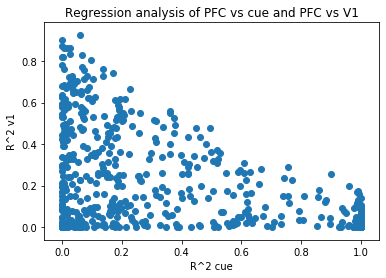

In [87]:
# N_PFC_NEURONS = 500
CUE_TIME = 100
    
rsquareds = np.zeros((N_PFC_NEURONS, 2))  
for neuron_idx in range(N_PFC_NEURONS):
    
    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented
    
    trials = sample_trials()
    
    # Get cue 1 value and neuron activity for each trial
    # Only consider the activity over the second half of the cue period
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME
    
    cue = task_input[0, trials]
    v1  = v1v2_values[0, trials]
    neuron_activity = np.mean(rPFC_trials[trials, cuetime_s:cuetime_t, neuron_idx],1)
    
    # Compute linear regression
    
    X = np.transpose([np.ones(len(neuron_activity)), neuron_activity])
    rsquared_cue = logistic_regression(X, cue)
    rsquared_v1  = linear_regression(X, v1)
    rsquareds[neuron_idx,:] = [rsquared_cue, rsquared_v1]
    
plt.scatter(rsquareds[:,0], rsquareds[:,1])
plt.xlabel('R^2 cue')
plt.ylabel('R^2 v1')
plt.title('Regression analysis of PFC vs cue and PFC vs V1')
plt.show()

(array([99., 22., 25., 19., 22., 21., 16., 10., 16.,  7., 11.,  8., 10.,
        13., 11., 10., 10., 11., 10., 11.,  4.,  4.,  7.,  7.,  7., 11.,
         9.,  4., 13.,  5.,  5.,  7.,  4.,  8.,  3.,  6.,  3.,  6.,  2.,
         6.,  2.,  2.,  2.,  1.,  3.,  1.,  3.,  1.,  1.,  1.]),
 array([7.61794662e-06, 1.84094946e-02, 3.68113713e-02, 5.52132480e-02,
        7.36151247e-02, 9.20170014e-02, 1.10418878e-01, 1.28820755e-01,
        1.47222631e-01, 1.65624508e-01, 1.84026385e-01, 2.02428262e-01,
        2.20830138e-01, 2.39232015e-01, 2.57633892e-01, 2.76035768e-01,
        2.94437645e-01, 3.12839522e-01, 3.31241398e-01, 3.49643275e-01,
        3.68045152e-01, 3.86447029e-01, 4.04848905e-01, 4.23250782e-01,
        4.41652659e-01, 4.60054535e-01, 4.78456412e-01, 4.96858289e-01,
        5.15260165e-01, 5.33662042e-01, 5.52063919e-01, 5.70465795e-01,
        5.88867672e-01, 6.07269549e-01, 6.25671426e-01, 6.44073302e-01,
        6.62475179e-01, 6.80877056e-01, 6.99278932e-01, 7.17680809e-

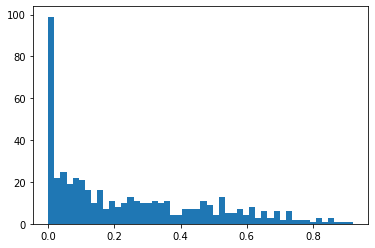

In [85]:
plt.hist(rsquareds[:,1], bins=50)
plt.title('R^2 V1 vs PFC activity histogram')